In [2]:
import os
import zipfile
import requests
from io import BytesIO
from typing import Tuple, List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, ResNet50, InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [3]:
# Parameters
img_size = (224, 224)
batch_size = 32

In [4]:
def create_dataframe_from_directory(path: str) -> pd.DataFrame:
    classes = []
    class_paths = []
    for label in os.listdir(path):
        label_dir = os.path.join(path, label)
        if os.path.isdir(label_dir):
            for image in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image)
                class_paths.append(image_path)
                classes.append(label)
    
    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

In [5]:
def plot_class_distribution(df: pd.DataFrame) -> None:
    plt.figure(figsize=(15, 7))
    ax = sns.countplot(data=df, y='Class', hue='Class', palette='viridis', dodge=False)
    
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Count of images in each class', fontsize=20)
    
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', padding=10)
    
    plt.show()

In [6]:
def plot_sample_images(generator, classes, num_samples=16):
    images, labels = next(generator)
    plt.figure(figsize=(20, 20))
    
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        class_name = classes[np.argmax(labels[i])]
        plt.title(class_name, color='k', fontsize=20)
    
    plt.show()

In [7]:
def create_image_generators(df_train: pd.DataFrame, 
                            df_valid: pd.DataFrame, 
                            df_test: pd.DataFrame,
                            batch_size: int = 16, 
                            img_size: Tuple[int, int] = (224, 224)) -> Tuple[ImageDataGenerator, ImageDataGenerator, ImageDataGenerator]:
    train_datagen = ImageDataGenerator(
        brightness_range=(0.8, 1.2),
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=40
    )
    
    valid_test_datagen = ImageDataGenerator()
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col='Class Path',
        y_col='Class',
        batch_size=batch_size,
        target_size=img_size,
        class_mode='categorical'
    )
    
    valid_gen = valid_test_datagen.flow_from_dataframe(
        dataframe=df_valid,
        x_col='Class Path',
        y_col='Class',
        batch_size=batch_size,
        target_size=img_size,
        class_mode='categorical'
    )
    
    test_gen = valid_test_datagen.flow_from_dataframe(
        dataframe=df_test,
        x_col='Class Path',
        y_col='Class',
        batch_size=batch_size,
        target_size=img_size,
        shuffle=False,
        class_mode='categorical'
    )
    
    return train_gen, valid_gen, test_gen

In [7]:
def build_model(base_model_name: str, num_classes: int) -> Model:
    if base_model_name == 'Xception':
        base_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x) 
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
def plot_training_history(history: tf.keras.callbacks.History) -> None:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [9]:
def plot_confusion_matrix(y_true: pd.Series, y_pred: List[str], class_names: List[str]) -> None:
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [10]:
# Load and prepare data
train_path = './Dataset/train'
test_path = './Dataset/test'

In [11]:
train_df = create_dataframe_from_directory(train_path)
test_df = create_dataframe_from_directory(test_path)

In [12]:
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20)

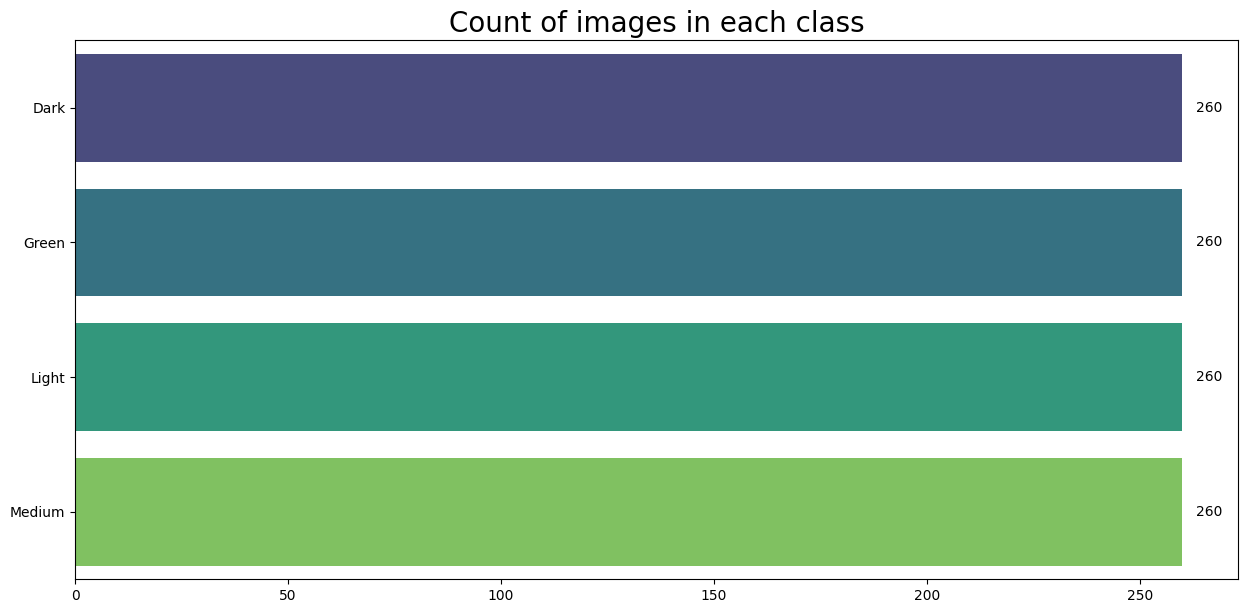

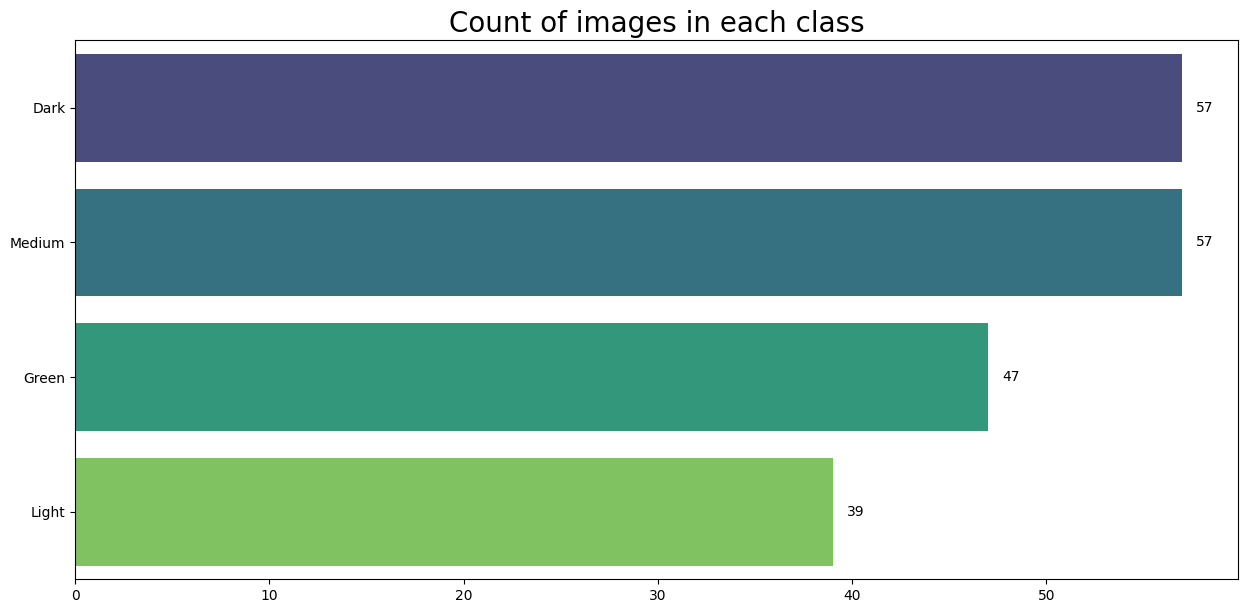

In [13]:
plot_class_distribution(train_df)
plot_class_distribution(test_df)

In [14]:
train_gen, valid_gen, test_gen = create_image_generators(train_df, valid_df, test_df, batch_size=batch_size, img_size=img_size)

Found 1040 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.


In [15]:
num_classes = len(train_gen.class_indices)

In [16]:
# Build and compile model
base_model_ResNet50 = 'ResNet50'  
# base_model_Xception = 'Xception'  
# base_model_InceptionV3 = 'InceptionV3'  

model_ResNet50 = build_model(base_model_ResNet50, num_classes)

In [17]:
model_ResNet50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

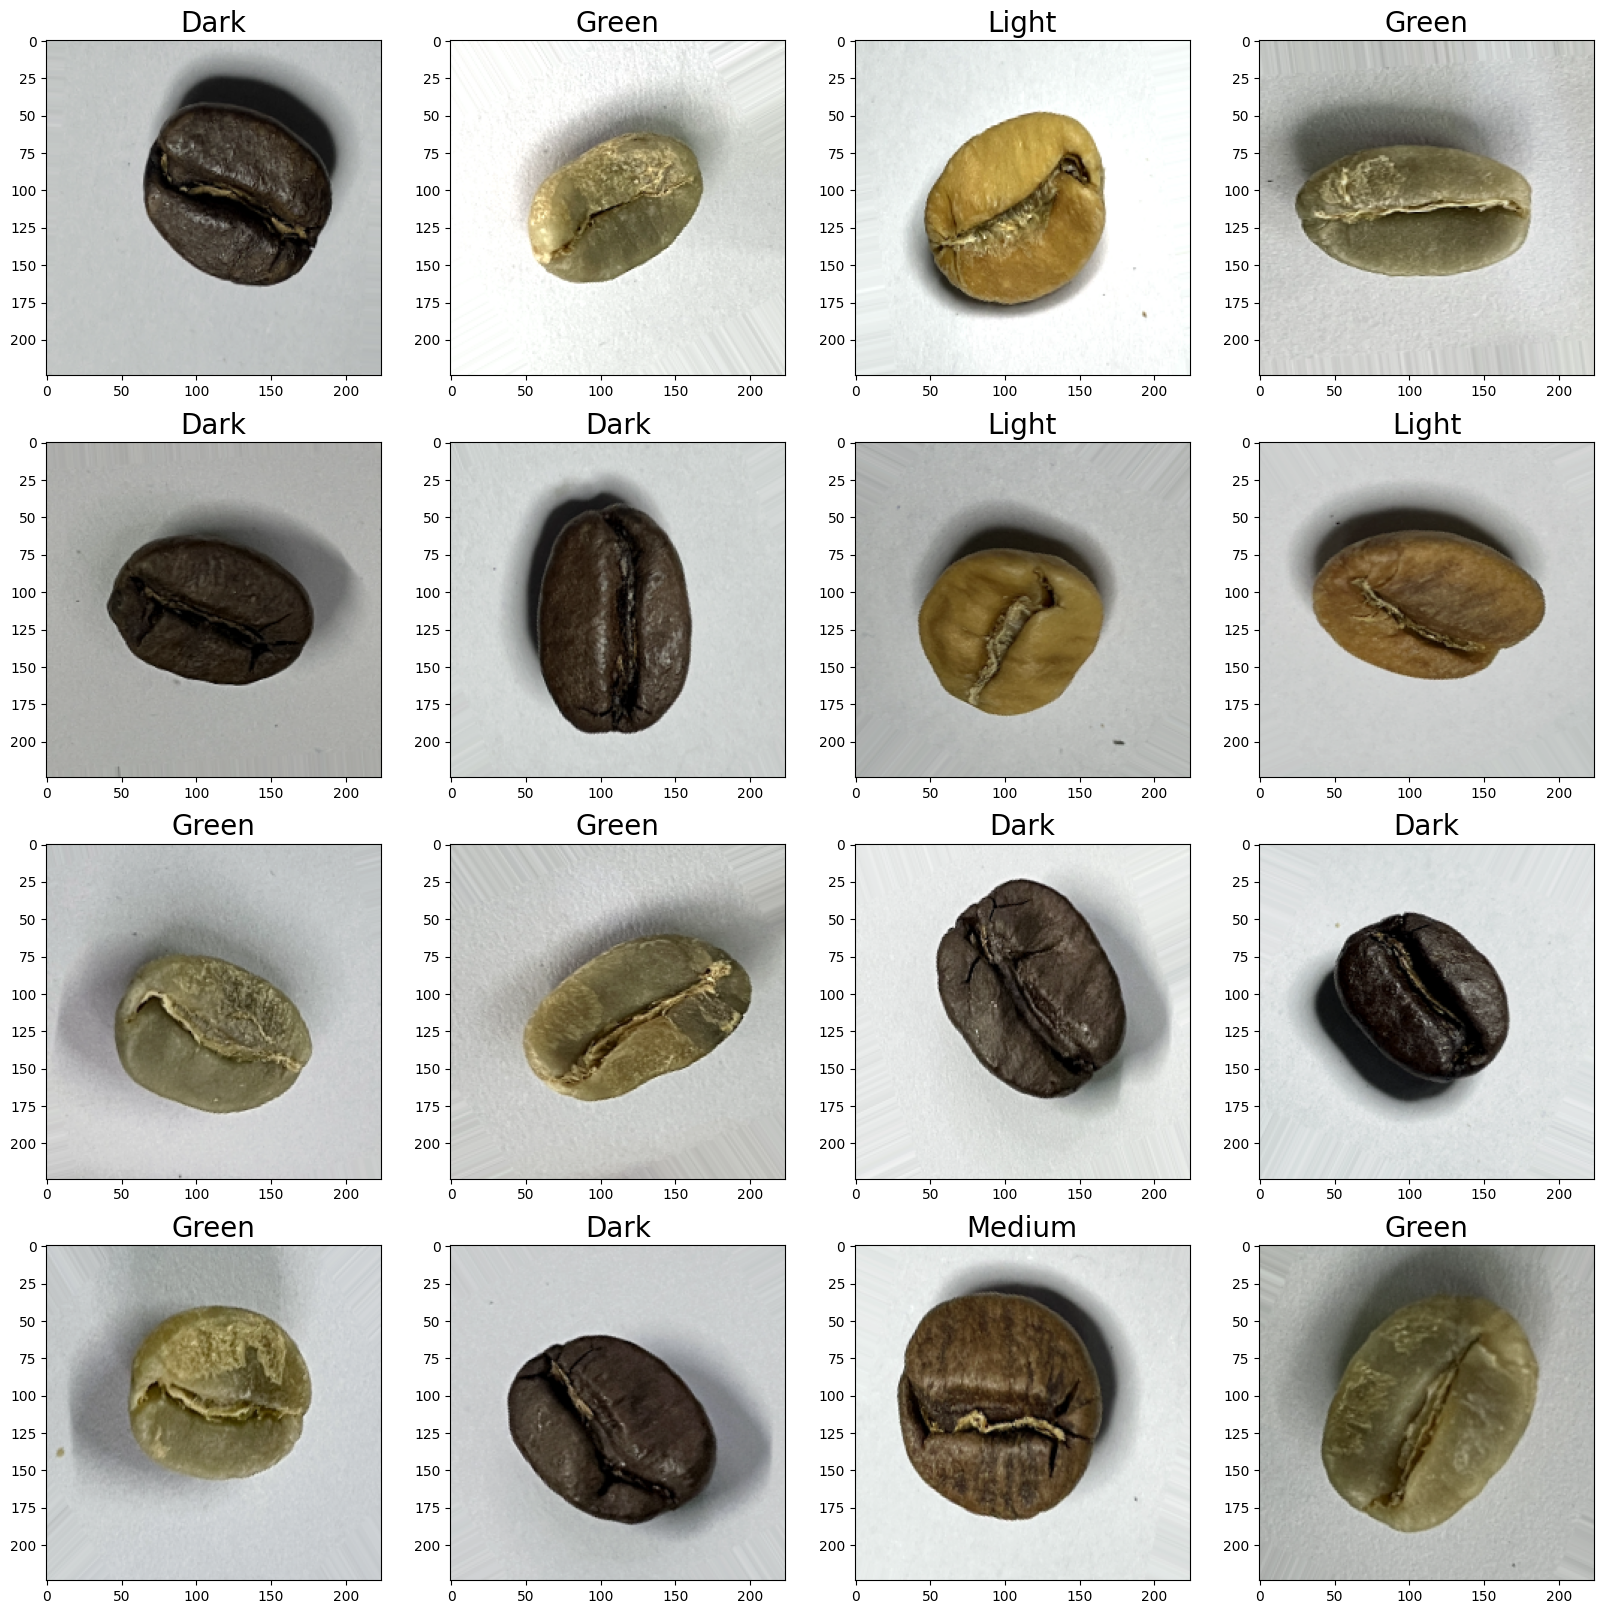

In [18]:
# Plot sample images
class_dict = train_gen.class_indices
classes = list(class_dict.keys())
plot_sample_images(train_gen, classes)

### Train the model

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [20]:
history_ResNet50 = model_ResNet50.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/5


c:\Sevann\UBA\vision_computadora_II\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 349s 10s/step - accuracy: 0.7520 - loss: 0.6635 - val_accuracy: 0.4550 - val_loss: 101.5429
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 321s 10s/step - accuracy: 0.9566 - loss: 0.1248 - val_accuracy: 0.7750 - val_loss: 11.5202
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 321s 10s/step - accuracy: 0.9903 - loss: 0.0525 - val_accuracy: 0.9900 - val_loss: 0.0215
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 318s 10s/step - accuracy: 0.9870 - loss: 0.0393 - val_accuracy: 0.9950 - val_loss: 0.0116
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 315s 9s/step - accuracy: 0.9780 - loss: 0.0560 - val_accuracy: 0.9950 - val_loss: 0.0080


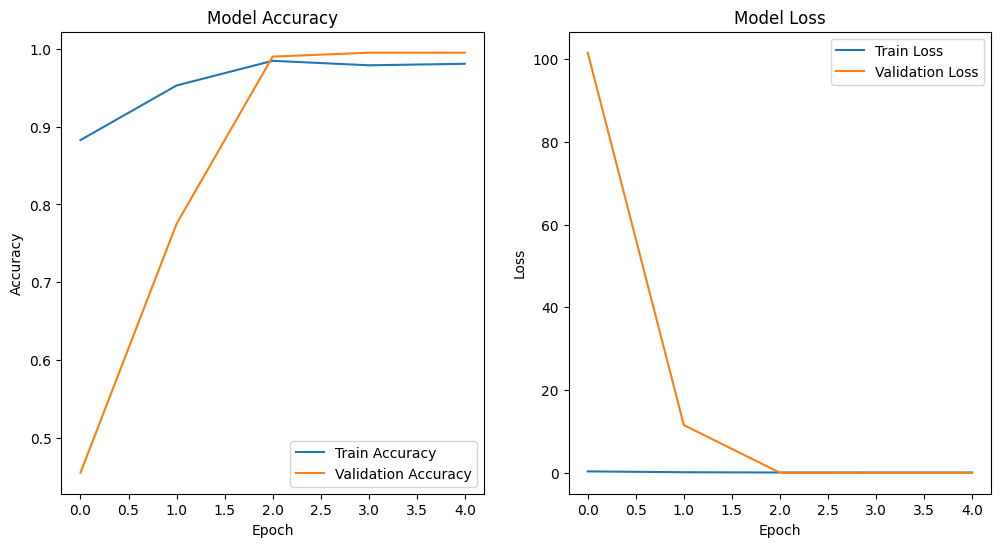

In [21]:
# Plot training history
plot_training_history(history_ResNet50)

In [22]:
# Evaluate the model
test_gen.reset()
y_pred_ResNet50 = model_ResNet50.predict(test_gen)
y_pred_classes_ResNet50 = np.argmax(y_pred_ResNet50, axis=1)
class_names = list(train_gen.class_indices.keys())

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [23]:
# Convert predictions to class names
y_true = test_df['Class']
y_true_labels = y_true.astype(str)
y_pred_labels_ResNet50 = [class_names[idx] for idx in y_pred_classes_ResNet50]

In [24]:
# Print classification report and accuracy
print(classification_report(y_true_labels, y_pred_labels_ResNet50))
print(f"Accuracy: {accuracy_score(y_true_labels, y_pred_labels_ResNet50):.4f}")

              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00        57
       Green       1.00      1.00      1.00        47
       Light       1.00      1.00      1.00        39
      Medium       1.00      1.00      1.00        57

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.0000


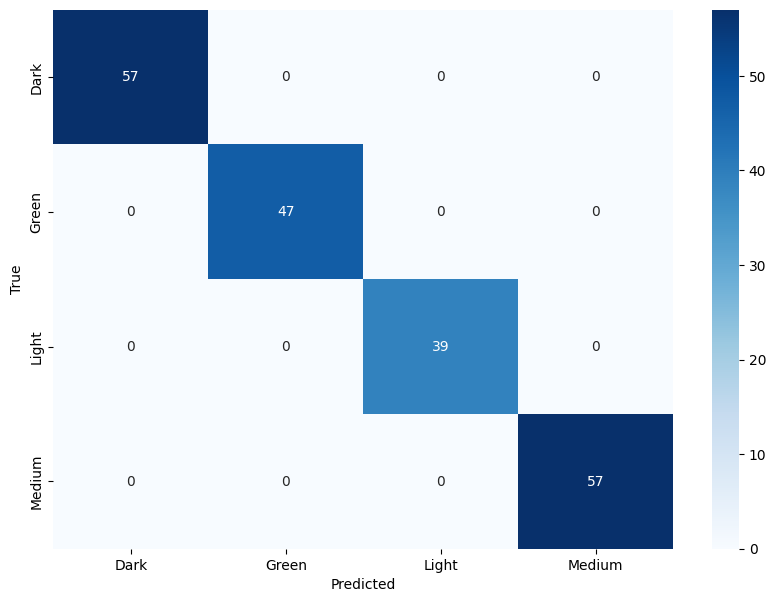

In [25]:
# Plot confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels_ResNet50, class_names)

## Xception

In [26]:
base_model = 'Xception'   
model_Xception = build_model(base_model, num_classes)

In [27]:
model_Xception.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

### Train model

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [29]:
history_Xception = model_Xception.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 462s 13s/step - accuracy: 0.7785 - loss: 0.5286 - val_accuracy: 0.7250 - val_loss: 0.8956
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 439s 13s/step - accuracy: 0.9767 - loss: 0.0671 - val_accuracy: 0.9800 - val_loss: 0.0481
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 485s 15s/step - accuracy: 0.9860 - loss: 0.0398 - val_accuracy: 0.9850 - val_loss: 0.0204
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 508s 15s/step - accuracy: 0.9954 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 7.2351e-04
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 496s 15s/step - accuracy: 0.9927 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 7.4590e-04


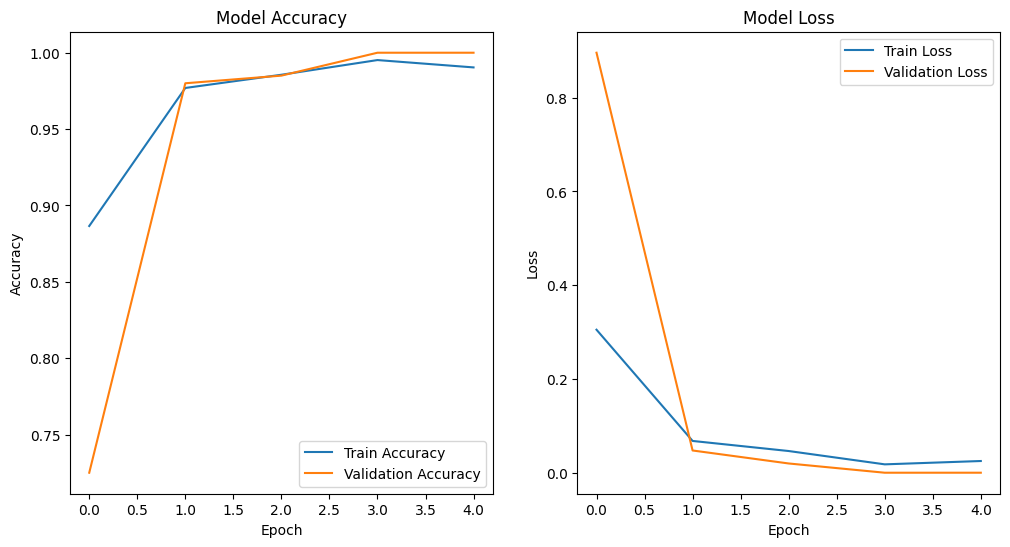

In [30]:
# Plot training history
plot_training_history(history_Xception)

In [31]:
# Evaluate the model
test_gen.reset()
y_pred_Xception = model_Xception.predict(test_gen)
y_pred_classes_Xception = np.argmax(y_pred_Xception, axis=1)
class_names = list(train_gen.class_indices.keys())

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [32]:
# Convert predictions to class names
y_true = test_df['Class']
y_true_labels = y_true.astype(str)
y_pred_labels_Xception = [class_names[idx] for idx in y_pred_classes_Xception]

In [33]:
# Print classification report and accuracy
print(classification_report(y_true_labels, y_pred_labels_Xception))
print(f"Accuracy: {accuracy_score(y_true_labels, y_pred_labels_Xception):.4f}")

              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00        57
       Green       1.00      1.00      1.00        47
       Light       0.97      1.00      0.99        39
      Medium       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200

Accuracy: 0.9950


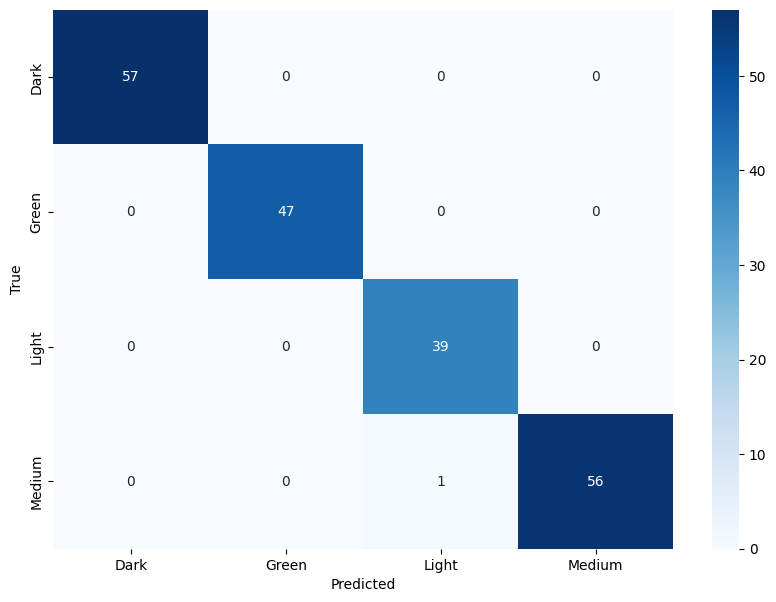

In [34]:
# Plot confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels_Xception, class_names)

## Modelo Alternativo

In [35]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Modelo
# model = Sequential()

# # Capa 1
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), 
#                  kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Capa 2
# model.add(Conv2D(64, (3, 3), activation='relu', 
#                  kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Capa 3
# model.add(Conv2D(128, (3, 3), activation='relu', 
#                  kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flatten y Fully Connected
# model.add(Flatten())
# model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
# model.add(Dropout(0.5))  # Incrementando la tasa de Dropout
# model.add(Dense(10, activation='softmax'))

# # Compilación
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Data Augmentation
# datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Entrenamiento
# train_generator = datagen.flow_from_directory('data/train', target_size=(224, 224), batch_size=32, class_mode='categorical')
# model.fit(train_generator, epochs=50, steps_per_epoch=200)
